# **Sequence to Sequence (Seq2Seq) Models - Aplicação em Geração de Poemas**

- Neste notebook, vamos construir um algoritmo capaz de aprender o estilo de escrita de Robert Frost para, então, gerar poemas com o mesmo estilo literário.

In [ ]:
#Garantir que está usando a versão mais recente de Keras
! pip install keras --upgrade

# **Sequence-to-Sequence (Seq2Seq) Models**

Suponha que estejamos construindo uma rede neural para tradução de textos.
- A tradução poderá conter um número de palavras (ou número de caracteres) diferente do total de palavras do texto de input:

"I am learning English" - 4 palavras;

"Sto imparando inglese" - 3 palavras;

"Estou aprendendo inglês" - 3 palavras.

- Em uma RNN padrão, tomar as saídas em cada ponto no tempo resultará em uma saída sempre do mesmo tamanho que a entrada.
- A solução para este problema é a arquitetura Seq2Seq.


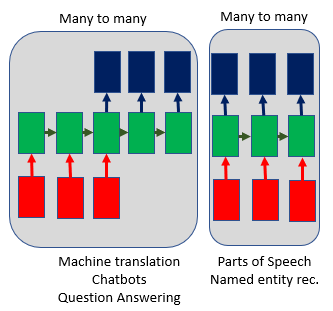

A arquitetura Seq2Seq é um duplo sistema de RNNs.
- O primeiro sistema processa os inputs. Ele é chamado de "**Encoder**".
- O segundo sistema produz a tradução (ou a resposta a uma dada pergunta, no caso de um chatbot ou assistente de consultas). Ele é chamado de "**Decoder**".

Basicamente, é a mesma ideia geral vista em diversas aplicações do deep learning: tomamos uma entrada bruta ("raw input"), a qual pode ser um texto, som, ou imagem, **e criamos um vetor que representa este dado numericamente**. A criação da representação numérica da sequência de palavras é feita pelo primeiro sistema (encoder).
- Note que o vetor resultante é uma **representação comprimida ("compressed data") do texto de entrada**.

O decoder (2º sistema) utiliza esta representação comprimida para gerar novos dados (correspondentes à tradução ou à resposta).
- Assim, o decoder "descomprime" os dados, mas em uma nova forma adequada à saída desejada (um outro idioma, por exemplo).

A aplicação mais básica e imediata deste algoritmo é um sistema de tradução automática ("auto-encoder") de texto escrito ou de som reproduzido.

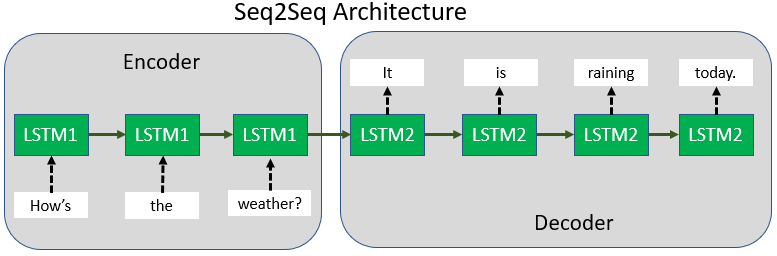

# **Funcionamento do Encoder**

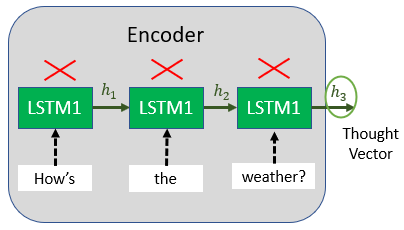

- Este sistema funciona como uma RNN padrão, na qual temos unidades recursivas LSTM ou GRU.
- É fornecida uma sequência de entrada (inputs), e **é retornada uma série de valores de hidden states h**.
- Não existem saídas (outputs), pois este primeiro sistema não realiza previsões.

IMPORTANTE: No **primeiro sistema RNN, desejamos manter somente o estado final hₜ (e o correspondente cell state cₜ**, caso estejamos utilizando o LSTM).
- No diagrama acima, são mostrados apenas os estados h para manter a simplicidade (os estados c que deixam as unidades são omitidos para não poluir a imagem).

Em Keras, isto implica utilizar o argumento:

```
return_sequences = False
```
Assim, a saída do primeiro sistema será hₜ, um vetor de dimensão M.
- De toda a sequência de entrada, **o que deixa o Encoder é apenas um vetor de comprimento estático M**.
- Você pode entender este vetor de saída como um **vetor de pensamentos ("thought vector")**.
- Este vetor não contém nenhuma informação temporal, mas representa toda a sequência de input.

Por esta razão, a saída é dita um encoding: uma representação compacta da entrada original.
- Outra forma de entender o processo encoding-decoding é imaginar a informação original como uma folha de papel contendo uma carta ou mensagem codificada a ser enviada a um receptor.
- O encoder dobra a folha em uma forma mais compacta, para que ela seja transportada até o receptor.
- No decoding, o receptor desdobra e decodifica a mensagem, possibilitando a sua interpretação.


# **Funcionamento do Decoder**

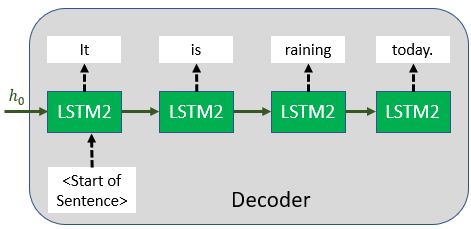

- A RNN do Decoder pode possuir seus próprios pesos, independentes dos pesos do primeiro sistema (encoder). Entretanto, em geral utilizamos no decoder
- A unidade RNN deve apresentar a mesma dimensão vetorial M, já que o input deste novo sistema (hₒ) é o vetor de pensamentos hₜ obtido como saída do Encoder.
- Além disso, é fornecido um token `<Start of Sentence>` ao input x da RNN. Este token informa o ponto no qual a nova sequência textual é iniciada.
- Tipicamente, este token é fornecido ao início da sentença e é demarcado pelas tags < e > ("angle brackets") - Devemos nos lembrar de adicionar os tokens ao dataset de treinamento.

A RNN utilizará o valor hₒ para calcular h1. Com h1, é possível calcular y1.
- **y1 será um vetor de probabilidades, a partir do qual podemos obter um valor de máxima probabilidade. Este valor máximo será correspondente à palavra ou expressão com maior probabilidade de corresponder à tradução para a língua desejada** ("target language").

# **Como prever a tradução da segunda, terceira, etc. palavra?**

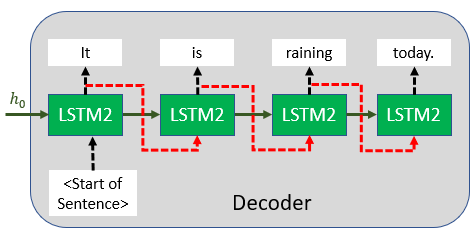

A palavra yi calculada anteriormente é passada como input xi+1 da RNN seguinte.
- Assim, a saída y1 da primeira RNN é usada como entrada x2 da RNN seguinte;
- Analogamente, a saída y2 da segunda RNN será a entrada x3 da RNN seguinte.

NOTA: acrescentamos uma ou mais camadas densas ("dense layers") após a saída da última LSTM.

# **Trabalho com sequências de tamanho constante**

- A princípio, este não parece ser um problema, mas repare novamente na figura:

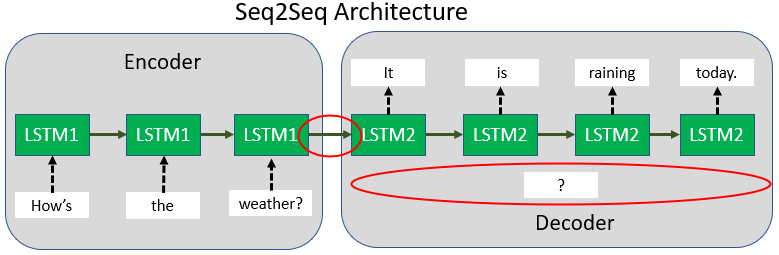

# **Teacher forcing**

Lembre-se que, **considerando os hidden states prévios como alimentação, cada RNN possui 2 inputs e ao menos uma saída**.
- Quando alimentamos o sistema Encoder-Decoder com a sequência de palavras a ser traduzida, as saídas das RNNs do sistema de encoding são, na realidade, ignoradas. **Isso porque queremos apenas o último hidden state do sistema de encoding**.
- Já no **sistema de decoding, nós tomamos as saídas e comparamos com os elementos da sequência "target"**. No caso de "machine translation", isto consiste simplesmente na sequência de input traduzida para um determinado idioma.

Observando novamente a imagem acima, repare que, no primeiro sistema (encoding), as RNNs apresentam 2 inputs: a sequência de palavras a serem traduzidas e o hidden state prévio.
- O que existe então na parte inferior das RNNs do sistema de decoding, destacada na imagem acima como uma interrogação?

Vimos anteriormente neste notebook que podemos usar a saída da unidade RNN como alimentação da unidade RNN seguinte (linhas vermelhas tracejadas).
- Embora esta **metodologia seja boa para realização de previsões**, pesquisadores descobriram que existe uma abordagem que funciona melhor para treinamento: é o chamado "**teacher forcing**".

# **Funcionamento do Teacher Forcing**

- Ao invés de alimentar uma unidade RNN com a saída da unidade anterior, nós **alimentamos cada unidade do decoder com a palavra target verdadeira**.
- Como se trata de dados de treinamento, teremos não só a tradução que o modelo previu (que pode ou não estar certa, já que ele ainda está aprendendo a traduzir), mas também a palavra que de fato deve ser gerada ao fim (a tradução correta, já validada). Esta resposta correta é o target verdadeiro ao qual nos referimos acima.
- Existe um offset correspondente ao token `<Start of Sentence>`.

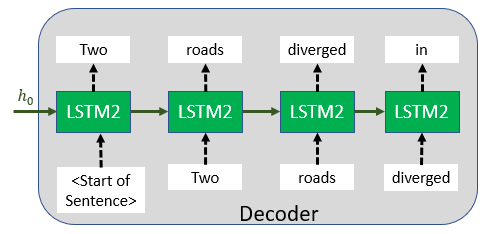

- Mesmo que o modelo não tenha obtido corretamente a palavra anterior, o "teacher forcing" corrige o modelo.
- Assim, **o modelo consegue prever a próxima palavra com base na tradução correta**.

Esta abordagem auxilia o treinamento porque **seria difícil para o modelo gerar a sequência traduzida completa de uma vez só**.
- Esta situação é o que ocorre comumente em aulas de idiomas: se o estudante escreve ou fala equivocadamente uma das palavras, o professor o corrige, e o aluno utiliza esta informação corrigida para finalizar o restante da sentença.
- Se você traduzir erradamente uma palavra e não houver correção, todas as previsões futuras serão de certa forma desperdiçadas, pois a frase inteira contém um erro inicial.

Repare que o offset de uma unidade recorrente associado ao token `<Start of Sentence>` está relacionado ao fato de que estamos sempre tentando prever a palavra seguinte.
- **Se houvesse alinhamento perfeito das palavras, o decoder aprenderia a simplesmente copiar o input no output**, algo sem utilidade.

Como Keras trabalha com sequências de tamanho constante, se o input apresentar comprimento 100, o output também apresentará comprimento igual a 100.
- Suponha que o comprimento das sequências seja Ty. Neste caso, passamos sempre sequências de comprimento Ty durante o treinamento.
- Além disso, no treinamento temos os targets (respostas) verdadeiros para fornecer como input inferior do decoder.
- O problema é que **é impossível ou inviável garantirmos o comprimento constante quando trabalhamos com sequências quaisquer para as quais desejamos prever os resultados.**
- Por consequência, **também é impossível passarmos o target verdadeiro como input, uma vez que desejamos justamente conhecer as respostas**.

### **Assim, para o teste e para a realização de previsões, precisamos voltar à arquitetura original na qual a saída de uma unidade é utilizada como entrada da unidade seguinte (linhas tracejadas vermelhas)**.

- Com isso, o **tamanho das sequências será sempre 1, já que elas serão formadas por palavras ou tokens únicos**.
- Note que isto ocorre porque estamos **utilizando um loop (processo iterativo) que gera uma única palavra por vez** (por ciclo).
- Não é possível fornecer todos os valores Ty de uma vez só, já que estes valores ainda não foram gerados.

# **Resumindo a problemática:**

1) Keras precisa trabalhar com inputs (sequências) de mesmos comprimentos;

2) Ao utilizar "teacher forcing" para o treinamento, o comprimento das sequências de input do decoder é Ty = comprimento da sequência target (target = resposta = sequência traduzida para a língua desejada. **Treinamos a RNN com traduções corretas, as quais já conhecemos e validamos**);

3) Durante o teste, o comprimento das sequências de input do decoder é 1, pois utilizamos uma única palavra por vez (alimentamos uma unidade RNN com a palavra de saída e com o hidden state obtido na unidade anterior).

À primeira vista, a combinação dos problemas 2 e 3 está em desacordo com a questão número 1.

# **Solução: criação de 2 modelos**

Veja o pseudocódigo relacionado abaixo. O primeiro modelo que criamos é destinado apenas ao treinamento:

```
emb = Embedding(); lstm = LSTM(); dense = Dense();
input1 = Input(length = Ty)
model1 = Model(input1, dense(lstm(emb(input1))))
```
O segundo modelo é destinado à amostragem ("sampling"), e nós **utilizamos as camadas de decoding previamente definidas na criação do primeiro modelo**.

```
input2 = Input(length = 1)
model2 = Model(input2, dense(lstm(emb(input2))))
```
Assim, podemos definir um novo conjunto de inputs para o segundo modelo. Estes inputs apresentarão comprimento de sequência igual a 1 (sequências formadas por uma única palavra ou token).
- Note que, de fato, `model1` e `model2` usam as mesmas camadas definidas no início. A única diferença está no input fornecido a tais camadas: `input1` é substituído por `input2`.

O pseudocódigo para a tradução do texto é basicamente um loop `for`.
- Primeiramente, tomamos o hidden state final h do modelo do encoder, e assinalamos este valor como o h inicial do decoder.
- Também assinalamos o token de começo da sequência ao primeiro valor de input x.
- Com isso, podemos obter tanto a previsão da palavra de saída da primeira RNN (output) quanto o hidden state seguinte.
- A seguir, esta saída e o novo hidden state são utilizados como valores de input h e x da próxima unidade RNN, e o loop prossegue da mesma forma.
```
h = encoder model output; x = <Start of Sentence> = <SOS>
for t in range(Ty):
  x, h = model2.predict(x, h)
```
- Nós só conseguimos gerar uma única palavra por vez. Consequentemente, só podemos alimentar as unidades RNN com uma única palavra por vez, fazendo com que as sequências tenham sempre de ser de comprimento unitário.






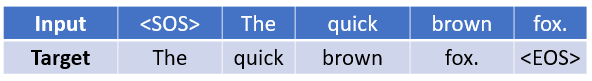

- Na imagem acima, o token `<SOS> =<Start of Sentence>`; enquanto `<EOS> = <End of Sentence>`.
- Note que o método do "teacher forcing" simplesmente calcula a probabilidade de se obter uma palavra em um instante t, dada a palavra obtida no instante t-1 (a palavra de maior probabilidade é a escolhida).
- Para isso, usamos uma sequência de target (resposta esperada = tradução já conhecida) que é simplesmente a sequência de input com um offset de 1 unidade recorrente.
- Note na imagem acima que as duas sequências são de mesmo comprimento.
- Construir o modelo desta forma **ensina a RNN a prever a próxima palavra, dada a palavra anterior em uma sentença**.


# **Exemplos de aplicação** 

## **Geração de poemas ("poetry generation") - Modelagem Linguística**

- A geração de poemas é um caso particular da modelagem linguística ("language modelling").
- As RNNs aprendem um modelo probabilístico a partir de um conjunto de poemas (textos de entrada). A partir daí, o sistema pode gerar novos poemas.
- O esquema anterior de "teacher forcing" permite a geração de poesia após o treinamento das redes neurais.
- **Novas sentenças são geradas a partir da distribuição de probabilidades de se encontrar uma nova palavra**. Basta realizarmos a amostragem ("sampling") da distribuição de probabilidades esperada para a saída da RNN.

A **única diferença entre a modelagem linguística ("language modelling") e o Seq2Seq está na entrada do sistema de decoding**:
- No Seq2Seq, o hidden state inicial no decoder é a saída hₒ do encoder;
- Em language modelling, o hidden state inicial ou é simplesmente um parâmetro arbitrário, ou é definido como sendo igual a zero.

A construção de um código para "language modelling" requer exatamente o mesmo código que a construção de um modelo Seq2Seq.

## **Responder perguntas ("Q&A - Questions and Answering")**

- Dada uma história, a RNN produz uma resposta. É um teste de compreensão da leitura.
- A história (contexto) e a pergunta são concatenadas de modo a formar uma única sequência de input;
- O Encoder converte a sequência de input em um vetor de pensamento ("thought vector");
- **O vetor de pensamentos é decodificado para formar uma resposta**.
- Uma base de dados utilizada aqui é exatamente igual ao Machine Translation Dataset: você possui sequências de palavras como inputs; e uma sequência alvo (target) de palavras. A rede neural é treinada para aprender a relacionar estes pares input-target.

## **Chatbots**

- A base de dados necessária pode ter exatamente o mesmo formato da anterior, utilizada para responder perguntas (Q&A).
- O usuário diz algo ao Chatbot, e ele retorna uma resposta.
- Assim, tanto chatbots quanto Q&A podem utilizar a mesma estrutura `requisição - resposta` que a tradução de textos ("neural machine translation").
- O usuário fornece como input uma sequência de palavras, e a saída (output) será outra sequência de palavras.
- Porém, a arquitetura Seq2Seq não é a melhor para os chatbots: conversas reais envolvem ideias que se espalham em múltiplas perguntas, respostas e afirmações. Este processo retro-alimentativo envolve todos os agentes envolvidos, e pode ocorrer retorno a um determinado tópico muito tempo depois de ele ter sido mencionado.
- Por sua vez, conversas formadas apenas por pares questão-resposta não apresentam fluidez e não são naturais.
- Assim, idealmente, o chatbot deve se lembrar não apenas do que foi dito anteriormente, mas do assunto como um todo.
- **A arquitetura Seq2Seq apenas ensina a memorizar pares pergunta-resposta, mas não ensina a ter uma conversa propriamente dita**.


# **Seq2Seq: Conclusões**

O sistema Seq2Seq permite resolver o problema de mapear uma sequência de input a uma sequência de output com dimensões diferentes.
- O sistema mapeia ou correlaciona uma sequência de comprimento Tₓ a uma segunda sequência de comprimento Ty, onde Tₓ != Ty (!= é o operador booleano "diferente de").
- A segunda sentença de comprimento Ty representa, por exemplo, a resposta ou a tradução da sentença de input.

Dados de tradução de vários idiomas estão disponíveis em:
http://www.manythings.org/anki/
- Todos os dados são iguais, mudando apenas o par `língua inicial - língua traduzida` (E.g. English to Spanish, English to Russian, etc).

# **Roteiro para construção de modelos em Keras**

1) Carregar os dados e convertê-los a um formato adequado para a construção do modelo. **As funções do Pandas são necessárias para converter bases gravadas como CSV ou arquivo Excel em objetos do tipo dataframe**, independente se os dados forem previamente carregados no Google Drive, se foram carregados diretamente no ambiente do Google Colab, ou se foram carregados offline usando uma IDE como o Anaconda.

2) Criar o modelo: aqui, forneceremos ao Keras a estrutura do modelo, por exemplo, tipos e configurações das camadas da rede neural, bem como a sequência das camadas e operações.

3) Treinar o modelo com os dados e avaliar seus resultados.

# **Fazer upload de arquivos a partir de sistema de arquivos local**

<code>files.upload</code> é um comando que retorna um dicionário Python com os arquivos incluídos no upload.
O dicionário é indexado com o nome do arquivo e os valores são os dados enviados por upload.

CONFIGURAR Ambiente do COLAB:
No menu superior, clique sobre a seta ao lado das barras RAM e Disco. No dropdown mostrado, selecione 
**"Ver recursos"**.

No novo menu, utilize a barra de rolagem até chegar ao extremo inferior, e selecione a opção **"Alterar o tipo de ambiente de execução"**.

Por fim, em **"Acelerador de hardware"**, selecione **"GPU"**.

Vamos carregar os arquivos com textos a serem classificados via RNN. Eles estão disponíveis nos links abaixo:

Download the word vectors:
http://nlp.stanford.edu/data/glove.6B.zip


Os arquivos glove.6B possuem vetores de palavras já definidos. Como os arquivos são muito pesados, é melhor carregá-los primeiramente no Google Drive para posteriormente trazê-los ao ambiente do Colab (carregar diretamente no Colab levará tempo excessivo).

# **Google Drive**

É possível acessar os arquivos no Drive de várias maneiras. Por exemplo:
- Montar o Google Drive na máquina virtual do ambiente de execução
- Usar um wrapper ao redor da API, <a href="https://pythonhosted.org/PyDrive/">como o PyDrive</a>
- Usar a <a href="https://developers.google.com/drive/v3/web/about-sdk">API REST nativa</a>



Veja abaixo exemplos de cada um eles.

# **Montar o Google Drive localmente - Autorizar conexão do Google Colab aos arquivos do Google Drive**

O exemplo abaixo mostra como montar o Google Drive no seu ambiente de execução usando um código de autorização, além de como gravar e ler arquivos nele. Depois de executado, você verá o novo arquivo &#40;<code>foo.txt</code>&#41; no <a href="https://drive.google.com/">https://drive.google.com/</a>.

Isto permite somente ler, gravar e mover arquivos. Para modificar de maneira programática as configurações de compartilhamento ou outros metadados, use uma das opções abaixo.

<strong>Observação:</strong> ao usar o botão "Montar Drive" no navegador de arquivos, não é necessário usar nenhum código de autenticação para notebooks que tenham sido editados somente pelo usuário atual.

In [ ]:
#Esta célula é utilizada para conectar à conta do Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


No menu à esquerda, clique sobre o ícone da pasta ("**Arquivos**"), e localize dentro da nova pasta "drive" a pasta do Google Drive contendo os arquivos desejados (clique na seta para expandir os dropdowns). 

Clique sobre a elipse (3 pontos à direita) do arquivo desejado e selecione a opção "**Copiar caminho**" para copiar os endereços de cada um dos arquivos que serão analisados.

Note que o caminho será diferente para cada usuário do Google Drive.

Endereços:

glove.6B.50d.txt: "/content/drive/MyDrive/Coisas úteis separadas para a Paula/Deep Learning - Advanced NLP and RNNs/Lesson 1 - convolutional neural networks/glove.6B.50d.txt"

Poesia modelo - Robert Frost: "/content/drive/MyDrive/Coisas úteis separadas para a Paula/Deep Learning - Advanced NLP and RNNs/Lesson 5 - Seq2Seq/robert_frost.txt"

# **Importar bibliotecas para análise**

In [ ]:
# Note: you may need to update your version of future
# sudo pip install -U future

import os
import sys
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense, Embedding, Input, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#from keras.optimizers import Adam, SGD

try:
  import keras.backend as K
  if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM
    from keras.layers import CuDNNGRU as GRU
except:
  pass

As bibliotecas "os" e "sys" possibilitam ler e fundir (merge) arquivos, como será visto adiante.

**Tokenizer**: transformar uma sentença (uma grande string contendo palavras e pontuação) em uma lista de strings, na qual cada elemento da lista é chamado de token.

Tokenização é um aspecto chave e mandatório do processamento de textos. Os tokens são os blocos de construção do processamento de linguagem natural, utilizados tanto em métodos tradicionais quanto nos mais modernos algoritmos de deep learning.

A tokenização consiste em separar um trecho de texto em unidades menores (tokens), as quais podem ser palavras, caracteres, ou subpalavras. A forma mais comum de formar tokens é a separação por meio da identificação de espaços em branco que demarcam a separação entre as palavras.

Assim, o token geralmente será uma palavra, mas pode ser pontuação, apóstrofe, parte de uma contração, etc, dependendo da estratégia de tokenização aplicada. Portanto, a tokenização pode ser vista como uma estratégia de split de strings.

**pad_sequences**: nós precisamos deste comando porque desejamos que todas as nossas sequências apresentem o mesmo comprimento. Porém, quando carregamos a sequência no ambiente, elas apresentam diferentes comprimentos.

Assim, nós adicionamos o padding para obter uma saída "reta".

# **Configurações das redes neurais e do processamento de texto**

In [ ]:
# some configuration
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 3000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 2000
LATENT_DIM = 25

**`BATCH_SIZE`**: quantos dados são usados em cada forward and backward pass. Se temos 3200 dados e o batch size é 32, ocorrem 100 passagens de 32 dados em cada época.

**MAX_SEQUENCE_LENGTH**: definimos em 100 por se tratarem de comentários de internet. Este parâmetro pode ser modificado: por exemplo, após carregar todos os dados, define-se este parâmetro como sendo igual ao maior comprimento presente. Outra estratégia é verificar o histograma dos comprimentos de comentários para averiguar se o parâmetro escolhido faz sentido.

**MAX_VOCAB_SIZE: tamanho do vocabulário de aprendizagem** (total de palavras do vocabulário). Se houver mais que MAX_VOCAB_SIZE = 3000, o vocabulário será truncado em 3000 palavras. Experimentos mostraram que um falante de inglês nativo conhece, em média, cerca de 3000 palavras. Embora estes resultados sejam controversos e provavelmente superestimados, este é um valor popularmente adotado para este parâmetro.

**EMBEDDING_DIM**: comprimento de cada vetor de palavras (word vector). Você não pode escolher qualquer comprimento quando trabalhando com modelos pré-treinados. Isto porque os *modelos pré-treinados costumam vir com determinados valores de comprimento de vetor de palavras fixados*. Aqui, usaremos vetores de comprimento 50 ou 100, mas comprimentos iguais a 200 e 300 também estão disponíveis nos arquivos.

In [ ]:
# load in the data
input_texts = []
target_texts = []
for line in open('/content/drive/MyDrive/Coisas úteis separadas para a Paula/Deep Learning - Advanced NLP and RNNs/Lesson 5 - Seq2Seq/robert_frost.txt'):
  line = line.rstrip()
  if not line:
    continue

  input_line = '<sos> ' + line
  target_line = line + ' <eos>'

  input_texts.append(input_line)
  target_texts.append(target_line)


all_lines = input_texts + target_texts

# **Método `rstrip()`**

Este método corresponde à função **Trim**, a qual remove as formatações e espaçamentos em branco antes e após uma string ("**trailing spaces**").
- Repare que, uma vez que o tokenizer utiliza os espaços em branco para separar os tokens, a presença destes espaços extras poderia criar uma série de tokens vazios, ou mesmo retornar um erro.

**ATENÇÃO**

O endereço dos arquivos deve ser inserido com o número correto de espaçamentos. A inclusão de espaços em branco a mais no começo e no fim resultará em erro de processamento.

Note aqui a **particularidade do teacher forcing**: os inputs e os targets são, na realidade, as mesmas sentenças.
- Para acompanhar o percurso das sentenças de maneira correta, incluímos o token de começo da sentença `<sos>` à sequência de input; e incluímos o token de fim da sentença `<eos>` à sequência de target.
- Note que existe um espaço em branco nas strings:

```
'<sos> '
' <eos>'
```
- Isto está relacionado ao método de Tokenização, que procura pelos espaços em branco entre as palavras para separar os tokens. Assim, o espaço em `'<sos> '` separa este token da primeira palavra da sequência, enquanto que o espaço em `' <eos>'` separa o último elemento da sequência do token de encerramento.
- Como foi adicionado exatamente um token a cada sentença, as sequências continuam apresentando o mesmo comprimento, como requer o método Keras.
- Ao fim de cada iteração do loop, tanto a sentença (sequência de palavras) de input quanto a sequência de target são gravada como novos elementos das listas `input_texts` e `target_texts`, respectivamente.


Uma última etapa é a concatenação de todas as sentenças antes de treinar o tokenizer. Para isso, realizamos a concatenação das duas listas geradas:

```
all_lines = input_texts + target_texts
```
Repara que esta etapa é, de certa forma, ineficiente, porque estamos essencialmente duplicando cada sentença. Porém, isto facilita a compreensão e entendimento do código.


# **Aplicar o método keras.tokenizer para conversão das sentenças em números inteiros**

Esta é mais uma etapa de pré-processamento textual. Note que, até aqui, ainda temos uma lista que lembra uma serra, já que cada sentença ainda apresenta um comprimento diferente.
- Logicamente, a lista ainda é constituída por strings, o que não é processável pelas redes neurais (as redes neurais exigem que as strings sejam convertidas em valores numéricos).
- As strings ainda contêm os comentários completos, ou seja, ainda não foram tokenizadas.
- Devemos aplicar o **método tokenizer da biblioteca keras** para resolver estes problema: o **keras.tokenizer** converte as sentenças em listas de tokens e, a seguir, converte estas listas em números inteiros.
- Estes números inteiros serão usados para indexar o **word embedding** (a matriz contendo os vetores das palavras, na qual cada linha da matriz corresponde ao vetor numérico de uma palavra).

In [ ]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer.fit_on_texts(all_lines)
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

Repare que o método do ajuste do tokenizer é aplicado na segunda linha à lista concatenada (all_lines).

Mais uma vez, o tokenizer divide (split) as sentenças em tokens ou palavras individuais; e converte cada palavra em um índice inteiro a partir do qual a informação poderá ser recuperada pelo mapeamento.

Note ainda o seguinte argumento do tokenizer:

```
filters=''
```
### Estamos passando como argumento **filtros constituídos por strings vazias**.
- **Se não fizermos isto, o tokenizer filtrará (removerá) todos os caracteres especiais**.
- Tais caracteres são de importância para a geração de poesias, pois marcam oralidade, entonação, emoção, etc.
- Mais importante, **tanto o token de começo quanto o de fim da sentença contêm caracteres especiais < e >**.
- Assim, sem este argumento, os sinais que delimitam os tokens de início e fim seriam removidos.

Após treinar o tokenizer com todos os dados, aplicamos ele individualmente às listas de input e de output. Com isso, obtemos as sequências numéricas `input_sequences` e `target_sequences`.


# **Caracterização das sequências de texto obtidas e convertidas em inteiros**

Vamos caracterizar os comentários, agora que foram tokenizados e convertidos em números inteiros

In [ ]:
# find max seq length
max_sequence_length_from_data = max(len(s) for s in input_sequences)
print('Max sequence length:', max_sequence_length_from_data)

Max sequence length: 12


Note que aqui as sequências são, na realidade, os comentários, os quais podem conter mais de uma sentença. Porém, para os propósitos desta análise em particular, é mais simples chamar a string completa do comentário de sentença.

# **Associar cada palavra a uma linha (vetor de palavras) do word embedding**

Agora que as sentenças foram convertidas em números inteiros, surge a pergunta sobre a qual palavra cada número inteiro corresponde.
- Além disso, desejamos saber qual linha do word embedding pertence a cada palavra.
- Lembrando o que é o word embedding: **word embedding é a matriz dos vetores das palavras. Cada linha do word embedding representa o vetor numérico associado a cada palavra**. 
- Indexar aqui significa encontrar o índice do vetor (ou seja a linha do word embedding) que descreve cada uma das palavras tokenizadas.

Para isso, precisamos de um **mapeamento palavra-para-índice** (word to index mapping).
- Neste mapa, a chave (key) será a palavra, e o índice será o valor correspondente.
- **O keras.tokenizer mantém esta informação de mapeamento em um atributo chamado word_index**.

In [ ]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))
assert('<sos>' in word2idx)
assert('<eos>' in word2idx)

Found 3056 unique tokens.


# **Comando assert**

**Certifica que** tanto o token `<sos>` quanto o token `<eos>` **existem** no dicionário `word2idx`.
- É um teste de consistência dos dados.
- Caso a condição testada não seja verdadeira, o comando `assert` retornará uma mensagem de erro (exceção `AssertionError`, a qual encerra a execução do programa).
- Note que o objetivo do assert é auxiliar na depuração, verificando a sanidade interna do programa.
- Neste caso, o assert verificará o valor booleano (`True` ou `False`) de cada um dos testes: `'<sos>'` pertence ao dicionário?; e `'<eos>'` pertence ao dicionário?

Note que o mesmo atributo é utilizado para nos informar **quantas palavras foram encontradas no dataset: este valor será igual ao tamanho (length) do dicionário obtido**.

# **Limitar comprimento das sequências de texto com o método pad_sequences**

Neste momento, ainda temos um problema com nossos dados: os arrays continuam com tamanhos diferentes, formando um aspecto de serra.

- Para resolver este problema, a próxima etapa de pré-processamento será aplicar o **método pad_sequences, com comprimento máximo definido previamente na variável MAX_SEQUENCE_LENGTH**.

In [ ]:
# pad sequences so that we get a N x T matrix
max_sequence_length = min(max_sequence_length_from_data, MAX_SEQUENCE_LENGTH)
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='post')
target_sequences = pad_sequences(target_sequences, maxlen=max_sequence_length, padding='post')
print('Shape of data tensor:', input_sequences.shape)

Shape of data tensor: (1436, 12)


Esta etapa é particularmente importante porque a biblioteca **Keras trabalha com sequências de dimensões constantes**.
- O formato do tensor de dados representa a dimensão da matriz (N x T) obtida. Limitamos a 100 o máximo comprimento da sequência de textos.
- N = contagem de elementos;
- T será o máximo comprimento permitido para o vetor de palavras (máximo possível de colunas), definido como **MAX_SEQUENCE_LENGTH = 100**.

Note que, para que todas as sequências tenham o mesmo comprimento, **caso o vetor tenha um comprimento menor que MAX_SEQUENCE_LENGTH, o método pad_sequences adicionará vários números zero ao fim dele** até que ele atinja o comprimento máximo.

Uma questão que surge é como saber se o vetor ao qual foram adicionados os números zero não passou a ser igual a um outro vetor de palavras previamente definido no nosso vocabulário.
- Esta é uma questão válida, já que, ao construir o dicionário que correlaciona as palavras aos índices, nós utilizamos o zero para representar uma das palavras.
- Porém, **neste caso em particular, Keras inicia a indexação pelo número 1, e apenas utiliza o zero como um valor especial reservado para a operação de padding**.
- Desde que você **permaneça no ecossistema Keras durante as etapas de pré-processamento de texto**, a adição dos números zero não será um problema.

# **Vamos criar um dicionário vazio, chamado word2vec** 
Este dicionário armazenará os dados já pré-configurados, i.e., palavras que já foram convertidas em vetores numéricos, e que estão disponíveis nas bases glove.6B.

- O comprimento dos vetores de palavras será o definido e armazenado em EMBEDDING_DIM.
- O dicionário possui como estrutura: a palavra como a chave (key); e o vetor de palavras (word vector) como o valor correspondente.
- A nomenclatura word2vec vem de "word pointing to vector".
- Os arquivos glove.6B consistem em txt contendo a cada linha uma palavra seguida dos valores das componentes dos vetores, separados por espaços em branco.
- Assim, nós: 1) carregamos uma linha; 2) dividimos (split) as linhas em tokens; 3) tomamos o primeiro token como sendo a palavra; 4) tomamos os demais tokens como o vetor; 5) convertemos o vetor em um NumPy array; 6) e, por fim, salvamos cada array no nosso dicionário.

In [ ]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
#dicionário em branco, a ser povoado

with open(os.path.join('/content/drive/MyDrive/Coisas úteis separadas para a Paula/Deep Learning - Advanced NLP and RNNs/Lesson 1 - convolutional neural networks/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


Não imprima o dicionário word2vec! Devido ao seu tamanho elevado, sobrecarregará a visualização do notebook.

Note que ainda não começamos o treinamento das RNNs. O que fizemos aqui foi abrir uma série de arquivos de texto previamente carregados no Google Drive (arquivos contendo dados pré-treinados de palavras convertidas em vetores numéricos). Após abri-los com o comando with open, manipulamos as strings para que os dados povoassem um dicionário vazio.

Caso estivesse usando um ambiente offline, e não o Google Colab, o seguinte código deveria ser utilizado:

```
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('../large_files/glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))
```



Note que o trecho `glove.6B.%sd.txt' % EMBEDDING_DIM`

faz com que todos os arquivos com o número %s = EMBEDDING_DIM sejam lidos.


# **Pré-carregar a matriz de incorporação ("embedding matrix") que será utilizada pela rede neural**

No começo deste notebook, carregamos vetores de palavras previamente definidos, contidos no arquivo glove.

- A primeira coisa a fazer agora é verificar o número de palavras que será realmente utilizado como vocabulário da rede neural.

Este valor é simplesmente o mínimo entre MAX_VOCAB_SIZE = 3000, e o **comprimento (total de palavras) do dicionário** palavra-para-índice ("*word to index dictionary*") **somado a 1**.

Explicação:
- Lembre-se que definimos nos parâmetros de configuração inicial:
```
MAX_VOCAB_SIZE = 3000
```

- Entretanto, o número de palavras no dataset pode ser menor que 3000. Neste caso, nós não queremos que sejam criados 3000 vetores de palavras, mas sim o **menor número possível de vetores** (ou seja, armazenaremos menos que 3000 palavras).

- Por sua vez, o número de palavras pode ser superior a 3000. Nesta situação, **desejamos truncar os dados (o vocabulário) para que reste apenas MAX_VOCAB_SIZE = 3000 vetores**.

In [ ]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)

Filling pre-trained embeddings...


O trecho acima:

1) Verifica o total de vetores de palavras presente no vocabulário (o comprimento/dimensão do dicionário);

2) Compara este valor com MAX_VOCAB_SIZE.
- Se o tamanho do vocabulário for menor que MAX_VOCAB_SIZE, então MAX_VOCAB_SIZE é igualado ao tamanho do dicionário + 1 para que possamos trabalhar com o menor número possível de vetores de palavras (i.e., com menos palavras);
- Se a dimensão for maior que MAX_VOCAB_SIZE, truncamos o vocabulário de modo que ele terá apenas MAX_VOCAB_SIZE = 3000 palavras.

Note que **precisamos somar 1** em

```
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
```
**Porque, como visto, a biblioteca Keras inicia a indexação dos vetores de palavras em 1**, reservando o valor zero para as operações de padding.

Assim, se tivermos 3000 palavras, o índice da última palavra será efetivamente 3000, e não 2999 (índice esperado se a numeração começasse em zero, como comumente ocorre com as listas em Python).

Assim, caso deseje utilizar o índice para indexar um array, é necessário acrescentar um elemento. Isso porque, em Python, a numeração dos elementos dos arrays, assim como das listas, começa em zero.


Outra questão que pode surgir é: uma vez que tomamos o mínimo entre 3000 e o tamanho do vocabulário, o que ocorrerá se houver índices no array de dados maiores que 3000?

De fato, caso tente indexar um array por um número maior ou igual ao seu comprimento, o resultado será uma exceção ("*exception error*").

Felizmente, esta questão já foi resolvida anteriormente durante a criação do tokenizer:
```
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
```
Como utilizamos MAX_VOCAB_SIZE como um dos argumentos do método Tokenizer, **Keras já definiu que estes índices, caso existam, estarão fora dos tolkens do vocabulário**.

- OBS: comumente encontramos estas situações que foram assinaladas como fora dos tolkens referenciadas pela abreviatura **OOV** ("*out of vocabulary*").
- Outra abreviação comumente encontrada em comentários de códigos é **UNK, referente a unknown**.

# **Criação da matriz embedding**

A última etapa do pré-processamento do texto consiste em criar uma matriz V x D de zeros, que será o **embedding**. V é simplesmente o número de palavras num_words, o qual já calculamos, e D é a dimensão do embedding, EMBEDDING_DIM.

A seguir, criamos um loop que avalie cada palavra do dicionário palavras-para-índices ("word to index dictionary").

- **Se o índice for menor que o MAX_VOCAB_SIZE** (já corrigido para o caso de haver menos palavras que o definido nos parâmetros), **então ele deverá estar no embedding**.
- Esta etapa consiste, então, em uma tentativa de recuperar o vetor de palavras pré-treinado do dicionário de palavras.
- Lembre-se que os **vetores de palavras pré-configurados vêm de uma fonte (arquivos glove) diferente da fonte dos comentários classificados como tóxicos e utilizados como dados de treinamento** (arquivo train.csv). 
- Como os dados de treinamento é que são utilizados para construir o dicionário, **é possível que determinados vetores de palavras pré-treinados não sejam encontrados no dicionário** (as duas fontes de dados, glove e train, não são necessariamente equivalentes).



In [ ]:
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Repare que utilizamos o método **get** em:

```
word2vec.get(word)
```
Caso a chave (key) correspondente a um dos vetores de palavras pré-configurados não seja encontrada no dicionário (ou seja, caso aquela palavra não esteja presente no vocabulário de treinamento), **o método get simplesmente retorna um valor nulo como chave do dicionário, ao invés de gerar uma exceção, como ocorreria ao se tentar indexar um array ou lista**.

- O trecho acima também verifica, na sequência, se o vetor é nulo, em:
```
 if embedding_vector is not None:
```
- Caso o vetor não seja nulo, ele é assinalado à matriz de embedding na localização apropriada.



# **Criação de versão one-hot dos targets**

A função de "sparse cross-entropy" de Keras não funcionará se o input for uma sequência.
- Isto não era problema nos exemplos anteriores porque possuíamos apenas um target por input.
- Porém, agora **temos dois targets por input: cada amostra nos fornece uma sequência completa de targets**.

Como a "sparse cross-entropy" não foi projetada para este caso, seria teoricamente possível construir a própria função de perda.

Porém, **utilizar um one-hot encoding para fornecer uma quantificação numérica aos targets, baseando-se no seu índice em cada lista é a forma mais simples de contornar este problema**.

In [ ]:
# one-hot the targets (can't use sparse cross-entropy)
one_hot_targets = np.zeros((len(input_sequences), max_sequence_length, num_words))
for i, target_sequence in enumerate(target_sequences):
  for t, word in enumerate(target_sequence):
    if word > 0:
      one_hot_targets[i, t, word] = 1

Note que primeiro criamos uma matriz apenas com elementos nulos (np.zeros).
- A seguir, fornecemos o valor 1 apenas aos elementos especificados, de modo a diferenciá-los uns dos outros (ou seja, de modo a realizar o encoding destes elementos).

# **Método enumerate**

Cria uma numeração correspondente ao índice de uma lista. Como padrão do Python, **a indexação começa a partir de 0**. Porém, podemos passar o valor inicial da numeração como argumento do método, o que permite começar em 1. Exemplos:


```
>>> values = ["a", "b", "c"]

>>> for value in values:
...     print(value)
...
a
b
c

>>> for index in range(len(values)):
...     value = values[index]
...     print(index, value)
...
0 a
1 b
2 c

>>> for count, value in enumerate(values):
...     print(count, value)
...
0 a
1 b
2 c

>>> for count, value in enumerate(values, start=1):
...     print(count, value)
...
1 a
2 b
3 c
```



# **Construção e avaliação da RNN**

As etapas anteriores constituíram o pré-processamento do texto necessário à construção do modelo de redes neurais.

Estas etapas constituem cerca de 90% do código do notebook, e **muitas delas são genéricas e aplicáveis a diversos exemplos de NLP**.

# **Criação da camada de embedding**

A criação da camada de embedding consiste em simplesmente criar um objeto do tipo "**Embedding**".

In [ ]:
# load pre-trained word embeddings into an Embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  # trainable=False
)



print('Building model...')

Building model...


Os dois primeiros argumentos para construção da camada de embedding são o total de palavras "**num_words**" (tamanho do vocabulário); e a dimensão do embedding "EMBEDDING_DIM".

- A seguir, vem o argumento **"weights"**: nós passamos como argumento justamente **a matriz de embedding que construímos nas etapas anteriores**.
- O argumento **"input_length"** informa ao objeto embedding **quão longas nossas sequências serão. Este valor foi fornecido inicialmente em MAX_SEQUENCE_LENGTH**.
- No último argumento ("**trainable**") fornecemos o valor booleano **False pois não desejamos que os pesos sejam atualizados durante o procedimento de treino (estamos utilizando vetores pré-treinados** da base glove.6B).
- Logicamente, é permitido realizar a atualização, modificando-se o parâmetro para True. Porém, isto representará maior custo computacional e, possivelmente, um tempo longo de treinamento.

# **Construção do restante do modelo de redes neurais recorrentes (RNNs)**

Temos aqui um tensor de dados (variável "data") constituídos pelos comentários a serem classificados. É uma matriz N x T contendo os índices das palavras, na qual N é o total de amostras/dados e T é o comprimento da sequência.
- Temos também a variável "target", que representa os rótulos atribuídos a cada sequência. É uma matriz de dimensão N x 6, já que definimos 6 rótulos possíveis.
- Além disso, temos a matriz de embedding, de dimensão V x D, à qual já assinalamos alguns vetores de palavras. V é o tamanho do vocabulário e D é a dimensão do embedding.


Para construção da rede neural em Keras, o primeiro requisito é criar o objeto de input.

- Devemos especificar cada uma das dimensões, exceto o tamanho da amostra, o qual já está implícito.
- Como visto, o input usará como argumento um tensor de dados de dimensão N x T, onde N = contagem de elementos (tamanho de amostra, implícito), e T = máximo comprimento permitido para o vetor de palavras = **MAX_SEQUENCE_LENGTH = 100**.
- Assim, precisamos apenas fornecer T = MAX_SEQUENCE_LENGTH como argumento de criação do objeto de input.

A seguir, utilizamos este input como argumento da camada de embedding que criamos a pouco.

In [ ]:
# create an LSTM network with a single LSTM
input_ = Input(shape=(max_sequence_length,))
initial_h = Input(shape=(LATENT_DIM,))
initial_c = Input(shape=(LATENT_DIM,))
x = embedding_layer(input_)
lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x, _, _ = lstm(x, initial_state=[initial_h, initial_c]) # don't need the states here

Repare no trecho:
```
x = embedding_layer(input_)
```
Aqui está sendo utilizado o API funcional Keras ("Keras functional API") para passar o input como argumento da camada de embedding.
- Isto torna a sintaxe ligeiramente diferente da encontrada em outros códigos Keras que usam o modelo sequencial.



# **Unidade recursiva: LSTM**

- Após passar pela camada de embedding (assim como ocorre com as CNNs), os inputs têm de passar pela unidade recursiva.

- Aqui, especificamos a unidade recursiva como LSTM.
- Repare que definimos `return_sequences = True`, de modo que o sistema retorna todos os estados como valores de saída (e não apenas o último estado, como ocorre quando este parâmetro está em seu valor padrão, False).

# **Neste modelo, utilizamos 3 inputs:**

- Fornecemos a sequência de texto como input (padrão, igual aos outros exemplos).
- Além disso, também fornecemos como inputs o hidden state (`initial_h`) e o cell state (`initial_c`) iniciais.

O motivo para passarmos estes dois estados como inputs é que **desejamos ter controle sobre os valores iniciais que eles assumem**.
- Assim, impedimos que Keras defina por conta própria estes valores, utilizando, por exemplo, valores antigos ainda em memória.
- Isto se torna ainda mais importante pelo fato de que **passaremos estes mesmos estados na etapa de previsão**. Portanto, precisamos que haja consistência.

Uma vez que temos os inputs, criamos a rede LSTM mais simples possível, a qual consiste simplesmente no embedding, no LSTM e numa camada densa final, a qual realizará a previsão das palavras.

Repare que passamos `return_sequences = True` como argumento do LSTM.
- Fizemos isto porque a nossa saída precisa ser uma sequência, já que desejamos prever o restante da sentença.

Também passamos como argumento do LSTM `return_states = True`.
- Porém, como discutido na seção teórica inicial deste notebook, **na realidade ignoramos estes estados quando usando o LSTM**.
- Isto é observado no seguinte trecho do código, no qual o `_` é que é utilizado como **variável que armazenaria estes estados**:

```
x, _, _ = lstm(x, initial_state=[initial_h, initial_c])
```
O uso do `_` permite que o lado esquerdo da linha acima apresente o número correto de variáveis, mas sem armazenar os valores que ficariam guardados nas variáveis omitidas.

# **Camada densa ("dense layer")**

Para completar o modelo, submetemos a saída a última camada densa (assim como em redes neurais artificiais simples, camada completamente conectada). A função de ativação usada é softmax, que fornece uma abordagem probabilística ao cálculo de máximo e possibilita a captura de outros aspectos de não-linearidade.

In [ ]:
dense = Dense(num_words, activation='softmax')
output = dense(x)

# **Criação de um objeto do modelo ("model object")**

Agora que concluímos a construção do modelo, podemos assinalar ele a um objeto que armazenará as suas principais informações.

- **A função construtora ("constructor") deste objeto utiliza como primeiro argumento o input, e a saída ("output") como segundo argumento**.

In [ ]:
model = Model([input_, initial_h, initial_c], output)

Note que o objeto que armazena o modelo foi denominado "model".

### Mais uma vez, repare que além da sequência de input (`input_`), o hidden state (`initial_h`) e o cell state (`initial_c`) são utilizados como argumentos de entrada. Ja a saída do modelo estará, conforme os casos anteriores, em `output`.

# **Compilar o modelo para treinamento**

Neste exemplo, utilizamos a "categorical cross entropy" como função de perda ("loss function"), e não a "binary_crossentropy", conforme discutido

- Em "optimizer", utilizamos `adam` (escolha arbitrária). As outras opções disponíveis podem ser utilizadas aqui.

- Desejamos saber a precisão do modelo enquanto o treinamos. Para isso, passamos "accuracy" como parâmetro de compilamento do modelo.


In [ ]:
model.compile(
  loss='categorical_crossentropy',
  # optimizer='rmsprop',
  optimizer='adam',
  # optimizer=SGD(lr=0.01, momentum=0.9),
  metrics=['accuracy']
)

# **NOTA: aqui a precisão perde um pouco de seu sentido e até mesmo de sua relevância, já que estamos falando de gerar poemas.**

Assim, dada uma palavra da sequência, não existe necessariamente uma palavra seguinte correta. Podem existir dezenas de palavras possíveis para gerar a frase seguinte.



# **Treinar o modelo**

- Utilizamos o método **.fit** para treinar o modelo.
- **O modelo treinado ficará armazenado no objeto r** definido a seguir.

**Treinar o modelo de linguagem é igual a treinar o modelo Seq2Seq por teacher forcing**.

Com relação à realização de previsões, a geração de uma sentença traduzida utilizando o modelo Seq2Seq utiliza o mesmo processo aplicado à geração de poemas com o Language Model.

- Em tradução, desejamos realizar previsões corretas e exatas, de modo que sempre utilizaremos os máximos de probabilidade.
- Já em poesia, desejamos certo fator de aleatoriedade, de tal forma que as linhas sejam diferentes umas das outras.
- Assim, ao invés de tomar uma previsão exata, tomamos um elemento ao acaso da distribuição de probabilidades obtida como saída do modelo.

No trecho a seguir, o modelo é representado por `model`. 
- `r` representa um dicionário contendo diversas informações históricas a respeito do processo de treinamento do modelo.

Veja também que o hidden state e o cell state iniciais utilizados no processo de treinamento são dados por z. Na linha

```
z = np.zeros((len(input_sequences), LATENT_DIM))
```
Vemos que estes **valores iniciais são tomados arbitrariamente como sendo iguais a zero (criamos z como uma matriz nula)**.

### Como visto, esta é uma diferença importante entre o Language Modelling e o Seq2Seq: **em Language Modelling, tomamos arbitrariamente os estados iniciais como sendo iguais a zero, tanto no encoder quanto no decoder.** Já no Seq2Seq, os estados iniciais do decoder são iguais aos estados de saída do encoder.

In [ ]:
print('Training model...')
z = np.zeros((len(input_sequences), LATENT_DIM))
r = model.fit(
  [input_sequences, z, z],
  one_hot_targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Epoch 1/2000
9/9 [==============================] - 6s 111ms/step - loss: 5.6079 - accuracy: 0.0023 - val_loss: 5.6649 - val_accuracy: 0.0035
Epoch 2/2000
9/9 [==============================] - 0s 35ms/step - loss: 5.5674 - accuracy: 0.0065 - val_loss: 5.6189 - val_accuracy: 0.0072
Epoch 3/2000
9/9 [==============================] - 0s 35ms/step - loss: 5.4981 - accuracy: 0.0104 - val_loss: 5.5419 - val_accuracy: 0.0107
Epoch 4/2000
9/9 [==============================] - 0s 34ms/step - loss: 5.3931 - accuracy: 0.0190 - val_loss: 5.4366 - val_accuracy: 0.0203
Epoch 5/2000
9/9 [==============================] - 0s 34ms/step - loss: 5.2583 - accuracy: 0.0245 - val_loss: 5.3090 - val_accuracy: 0.0191
Epoch 6/2000
9/9 [==============================] - 0s 33ms/step - loss: 5.1043 - accuracy: 0.0221 - val_loss: 5.1761 - val_accuracy: 0.0197
Epoch 7/2000
9/9 [==============================] - 0s 35ms/step - loss: 4.9519 - accuracy: 0.0216 - val_loss: 5.0548 - val_accuracy: 0

### Acima, **nota-se que o treinamento de uma rede neural recorrente é muito mais lento que o de uma rede neural convolucional**.

- Embora tenhamos usado uma CNN com 3 camadas de convolução, enquanto essa RNN possui apenas uma camada LSTM, o processo de treinamento da RNN é ainda muito mais lento.
- Isto ocorre devido ao elevado número de parâmetros da LSTM, o que resulta em quantidade elevada de cálculos a serem realizados em cada epoch.

Note a estrutura de uma rede neural simples em Keras:

```
#Camada de entrada e camadas ocultas: utilize para cada uma delas o comando abaixo, onde N_NEURONIOS representa o total de neurônios utilizados
x = Dense(N_NEURONIOS, activation="relu")(input)

#Camada de saída:
x = Dense(1, activation="sigmoid")(x)

#Definição do modelo:
model = Model(inputs=input, outputs=x)
model.compile(loss="binary_crossentropy", optimizer="adam")
model.fit(X, y, n_epochs=100)
```
- "Activation" (função de ativação): "relu"; "sigmoid"; ou "tanh";
- Saída x = Dense(1, activation="sigmoid")(x): **aqui, o primeiro argumento é o total de variáveis de saída.** Se tivermos uma única saída (resposta única), o primeiro argumento será 1. No caso da classificação de toxicidade, estamos trabalhando com 6 saídas. **De forma mais genérica, o número de saídas é a dimensão da lista de rótulos,** razão pela qual usamos como input: **"len(possible_labels)"**.
- "loss", "optimizer" e "epochs" são hiperparâmetros das redes neurais, e podem ser modificados até se encontrar a melhor combinação deles.
- **"epochs": quantidade de vezes em que todo o dataset será utilizado na backpropagation** - é a **quantidade de ciclos de treinamento**;
- Número de camadas da rede neural simples: será igual à quantidade de operações "Dense" aplicadas.

Note que, **no caso da CNN, além das camadas "Dense" finais, temos as camadas de convolução e de agrupamento, de modo que o total de camadas não pode ser tomado como igual à quantidade de operações "Dense"**.

## **Até aqui, o que fizemos foi criar e treinar o language model**

Este modelo permite a nós "prever" (ou criar) a próxima palavra de uma frase, dado um conjunto de valores iniciais. Desta forma, o próprio modelo aprende a escrever um poema.

# **Salvar modelo treinado no Google Drive para re-importá-lo futuramente (ou baixá-lo no ambiente offline)**

Aqui, forneça o mesmo endereço da pasta na qual os arquivos das bases de dados foram salvos. Assim, o modelo ficará salvo na mesma pasta, facilitando sua localização.

In [ ]:
folder_adress = "/content/drive/MyDrive/Coisas úteis separadas para a Paula/Deep Learning - Advanced NLP and RNNs/Lesson 5 - Seq2Seq/"

In [ ]:
from keras.models import load_model
#Definicao do endereço e nome do novo arquivo:

file_address = folder_adress + "obtained_model.h5"
#file_address armazena o local em que sera salvo o modelo: o endereço da pasta foi concatenado
#ao nome e extensão desejados para o arquivo.
#note que o arquivo gerado se chama obtained_model.h5
#Em Keras, os modelos devem ser salvos com a extensão h5.

#Salvar modelo
model.save(file_address)


#Modelos Scikit-learn: use o modelo da biblioteca dill:
#import dill
#dill.dump(model, open(file_address, 'wb'))
#Nosso modelo foi gerado com a denominação "model", como vimos acima.
#aqui, modifique "model" pelo nome do modelo declarado, caso seja outro o nome utilizado
#note que o arquivo gerado se chama obtained_model.dill
#o dill permite salvar em qualquer extensao (pkl, sav, pmml, ...)

# **Reimportar modelo pré-treinado**

Para reimportar o modelo, basta seguir o código abaixo (ajuste-o de acordo com a pasta do drive na qual está salvo o modelo obtido anteriormente) - basta substituir o valor de "file_address" pelo endereço correto

In [ ]:
from keras.models import load_model
file_address = "/content/drive/MyDrive/Coisas úteis separadas para a Paula/Deep Learning - Advanced NLP and RNNs/Lesson 1 - convolutional neural networks/obtained_model.h5"

loaded_model = load_model(file_address)


#Em Sckit-learn
#import dill
#loaded_model = dill.load(open(file_address, 'rb'))
#Agora o modelo carregado  recebe o nome de loaded_model
#todos os campos que recebiam o nome do modelo devem ter o nome substituído para loaded_model
#você também pode modificar o nome loaded_model para um nome de seu interesse. Por exemplo:
#model = dill.load(open(file_address, 'rb')) fará o modelo ser carregado com o nome model

#ATENÇÃO: Caso já haja um modelo 1 com o nome escolhido para carregar este modelo 2, o modelo 1 deixará de existir, 
#sendo substituído pelo modelo 2 carregado.

# **Plotar gráfico da função de perda**

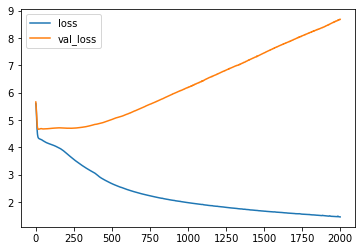

In [ ]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# **Plotar gráfico da precisão**

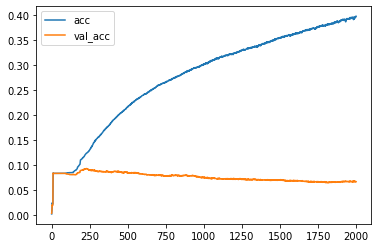

In [ ]:
# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

Como aqui estamos falando de geração de poemas, e uma quantidade virtualmente infinita de combinações de palavras é possível, sem que haja uma palavra seguinte "correta", **tanto a interpretação do overfitting quanto a métrica de precisão perdem bastante significado**.
- Em um poema novo, não desejamos que uma linha seja exatamente igual às demais e nem que seja igual às frases de treinamento. Isso por si só já reduz sobremaneira a precisão - não há uma sequência-alvo correta, como esperado para a tradução.

# **Construção do segundo modelo para o decoder**

Em Keras, precisamos especificar também os comprimentos das sequências ou séries temporais.
- Para o treinamento, o tamanho do input será simplesmente o comprimento da sequência mais longa a ser processada.
  - No treinamento (sistema encoder), nós alimentamos a rede com a sequência de input (frase) completa, e obtemos uma previsão para a palavra seguinte - tudo isto ocorre simultaneamente.
- Para os testes e previsões (sistema decoder), o tamanho do input é diferente. Nós só podemos passar uma palavra por vez, pois precisamos usar cada previsão como input da unidade recursiva seguinte.
  - Precisamos, então, construir um novo modelo, com novas entradas e novos tamanhos.


In [ ]:
# make a sampling model
input2 = Input(shape=(1,)) # we'll only input one word at a time
x = embedding_layer(input2)
x, h, c = lstm(x, initial_state=[initial_h, initial_c]) # now we need states to feed back in
output2 = dense(x)
sampling_model = Model([input2, initial_h, initial_c], [output2, h, c])

Aqui temos o modelo do decoder, no qual:
- A alimentação `input2` possui tamanho = 1 (ou seja, são **sequências formadas por uma única palavra ou token**);
- São utilizadas **exatamente as mesmas camadas definidas para o modelo de encoding** (os dois sistemas devem utilizar a mesma estrutura de redes neurais);
  - Caso fossem criadas novas camadas, haveria novos pesos aleatórios. Desejamos utilizar a mesma estrutura obtida para os dados de treinamento (encoder), incluindo os pesos já treinados.

### **Como usaremos os pesos treinados para o encoder, o processo de treinamento não é repetido para o decoder. Simplesmente aplicamos os novos inputs e tamanhos à estrutura de redes neurais já desenvolvida e treinada, gravada como `Model`.**

- Este o motivo pelo qual o argumento `return_states = True` ter sido fornecido durante a definição do LSTM: embora os estados não fossem necessários para o sistema de encoding (foram, inclusive, ignorados), precisamos dos valores deles para o sistema de decoding.
- Isso porque, como visto, cada unidade LSTM requer 3 inputs:
  - Vetor de palavras obtido como saída da unidade LSTM anterior ("current word vector");
  - Hidden state anterior ("previous hidden state"), saída da unidade anterior;
  - Cell state anterior ("previous cell state"), saída da unidade anterior.

Repare que só passamos os valores de estado z = 0 como estados iniciais no encoder. Após os estados iniciais, passamos os estados obtidos a cada unidade LSTM (os zeros são apenas para inicializar o algoritmo).
- Este o motivo pelo qual o sistema de decoding não é alimentado com valores iguais a zero.

Ao evocar o modelo com os parâmetros já treinados, estamos de certa forma aplicando ele manualmente. De fato, o código acima força Keras **a aplicar o modelo `Model` já obtido por teacher forcing para gerar as saídas (nova sequência de palavras)**.
- Para o sistema de encoding, quando treinamos as redes neurais, Keras realizou simultânea e automaticamente o ajuste dos parâmetros e o cálculo das saídas do modelo.

O novo modelo correspondente ao decoder e que utiliza a mesma estrutura de camadas que o modelo anterior é chamado `sampling_model`:

```
sampling_model = Model([input2, initial_h, initial_c], [output2, h, c])
```
Note em

```
input2 = Input(shape=(1,)) # we'll only input one word at a time
```
que o `sampling_model` toma um único índice de palavra ("word index"), um hidden state `initial_h` e um cell state `initial_c`.



Repare também em `output` que são retornados: 
- `output2`: enquanto Scikit-learn retorna a classe prevista, e é preciso solicitar expressamente o retorno das probabilidades, **Keras retorna diretamente as probabilidades associadas a cada classe**. Assim, `output2` será o vetor de probabilidades associado à palavra seguinte, a partir do qual se conhece a palavra de maior probabilidade.
- o hidden state `h` e o cell state `c` são novamente retornados, de modo que eles podem ser utilizados como a alimentação da unidade LSTM seguinte.

Como visto, cada unidade LSTM requer estes três parâmetros de entrada, a saída e os estados da unidade anterior.

In [ ]:
# reverse word2idx dictionary to get back words
# during prediction
idx2word = {v:k for k, v in word2idx.items()}

O modelo de redes neurais retornará apenas valores numéricos, os quais correpondem aos índices das palavras. 
- Precisamos, portanto, criar um mapeamento índice-palavras (i.e., informar a quais palavras correspondem cada um dos índices retornados).
- Isto permitirá que o modelo retorne sequências contendo palavras (sentenças).

### **O dicionário `idx2word`, portanto, correlaciona os índices numéricos a cada uma das possíveis palavras de saída**.

Assim, após as redes neurais retornarem um valor numérico, o algoritmo acessará este dicionário para coletar a palavra seguinte da sentença gerada.

# **Função `sample_line`**

Esta função gerará uma linha do poema a cada vez que for chamada.

- No início desta função, encontramos os inputs do modelo. Eles são localizados por meio do token sinalizador de início da sentença, `'<sos>'`. Na linha abaixo, vemos que o token de início da sentença é efetivamente tomado como a primeira palavra:
```
np_input = np.array([[ word2idx['<sos>'] ]])
```
Note que armazenamos as palavras em arrays 1x1: isto porque temos uma única palavra amostrada e, como visto, utilizamos sentenças formadas por uma única palavra no decoder.

Além disso, para manter a consistência com o treinamento anterior, o hidden state h e o cell state c são definidos como inicialmente iguais a zero:
```
h = np.zeros((1, LATENT_DIM))
c = np.zeros((1, LATENT_DIM))
```
Como visto, a definição dos estados iniciais iguais a zero tanto no encoder quanto no decoder é uma particularidade do Language Modelling. **Em Seq2Seq (para tradução, por exemplo), os estados iniciais do decoder seriam os estados de saída do encoder**.

Na sequência, a função localiza o token sinalizador de fim da sentença, de modo a saber onde parar:

```
eos = word2idx['<eos>']
```
Ou o algoritmo parará ao encontrar `'<eos>'`, ou ao atingir o parâmetro `MAX_SEQUENCE_LENGTH` (dependendo de qual for alcançado antes).

Na sequência, é criada uma lista para armazenar as palavras geradas, antes de iniciar o loop principal:

```
output_sentence = []
```



In [ ]:
def sample_line():
  # initial inputs
  np_input = np.array([[ word2idx['<sos>'] ]])
  h = np.zeros((1, LATENT_DIM))
  c = np.zeros((1, LATENT_DIM))

  # so we know when to quit
  eos = word2idx['<eos>']

  # store the output here
  output_sentence = []

  for _ in range(max_sequence_length):
    o, h, c = sampling_model.predict([np_input, h, c])

    # print("o.shape:", o.shape, o[0,0,:10])
    # idx = np.argmax(o[0,0])
    probs = o[0,0]
    if np.argmax(probs) == 0:
      print("wtf")
    probs[0] = 0
    probs /= probs.sum()
    idx = np.random.choice(len(probs), p=probs)
    if idx == eos:
      break

    # accuulate output
    output_sentence.append(idx2word.get(idx, '<WTF %s>' % idx))

    # make the next input into model
    np_input[0,0] = idx

  return ' '.join(output_sentence)

A primeira ação do loop é realizar uma previsão, retornando os valores de output `o`, de hidden state `h` e de cell state `c`.

```
o, h, c = sampling_model.predict([np_input, h, c])
```
O parâmetro `o` será uma lista de probabilidades para a próxima palavra, de onde tiraremos a próxima palavra amostrada.

Repare que as nomenclaturas `h, c` são as mesmas dos dois lados da linha de código acima. Portanto, os estados `h, c` obtidos serão usados como input do método `predict` da iteração seguinte.

O próximo passo do loop consiste na escolha da palavra seguinte a ser gerada pelo poema.

Em alguns casos, o algoritmo pode retornar uma alta probabilidade para o índice 0, o que não faz sentido, já que, nesta situação, Keras inicia a indexação das palavras em 1, como visto. Assim, um alerta é gerado caso isto ocorra. **Em geral, este problema é resolvido aumentando-se o tempo de treinamento (aumentando-se a quantidade de epochs)**.

`OBS: estamos nos referindo aqui à indexação do dicionário word2vec, que contém os word embeddings já treinados para conversão de palavras em vetores numéricos. Este dicionário foi utilizado no início do notebook para construção da matriz de embedding.`

Em

```
probs[0] = 0
probs /= probs.sum()
```
Vemos que a probabilidade da palavra de índice 0 (a qual, na realidade, não existe) é definida como sendo igual a zero, e o **vetor de probabilidades é renormalizado. Desta forma, garantimos a obtenção de uma distribuição de probabilidades válida**.



# **Função `numpy.random.choice`**

Esta função retorna um valor aleatório a partir de um array de input unidimensional.

```
np.random.choice(len(probs), p=probs)
```
Quando o primeiro parâmetro de entrada é um array unidimensional, será retornado um valor aleatório pertencente a este array.

Já quando o parâmetro é um número inteiro n, (como a dimensão do array `probs` no caso acima), é retornado um número aleatório dentro do intervalo [0, n), ou seja, começando em zero, mas excluindo n.

Por sua vez, o parâmetro `p` representa as probabilidades associadas a cada elemento (caso este parâmetro seja omitido, é assumida uma distribuição estatística uniforme).

Assim, a função `random.choice` escolhe um elemento de uma lista de números inteiros que começa em 0 e vai até (len(probs) - 1). Uma vez que `probs` é a lista das probabilidades associadas a cada uma das possíveis palavras que o algoritmo pode retornar, a lista de inteiros 0, 1, ..., (len(probs) - 1) nada mais é que **a sequência dos índices de cada uma das palavras na lista de palavras de saída possíveis**.

Desta forma, a mesma probabilidade `probs` associada a uma palavra pode ser associada ao índice desta palavra, já que a correspondência é bidirecional (associação bijetora).

Portanto, a função `random.choice` escolhe o índice de uma das possíveis palavras de saída, com base na probabilidade calculada para esta palavra e armazenada na lista `probs`. Este índice é armazenado na variável inteira `idx`.

No trecho

```
if idx == eos:
      break
```
Vemos que o loop para ao atingir o token que sinaliza término da sentença.




### **O segundo dicionário de mapeamento criado (`idx2word`), que correlaciona os índices numéricos a cada uma das possíveis palavras de saída é empregado para retornar a palavra correta**:

```
 output_sentence.append(idx2word.get(idx, '<WTF %s>' % idx))
```
O método `.get` retorna o elemento de saída (índice `idx` do dicionário `idx2word`). Este elemento é adicionado à lista `output_sentence` por meio do método `.append` (apêndice do elemento ao fim da lista).

Lembrando que os parâmetros de entrada da próxima unidade LSTM são os valores `np_input`, e os valores retornados `o, h`, **a função deve atualizar o valor `np_input` para a próxima iteração**. Ele é atualizado com o índice `idx` do dicionário `idx2word` correspondente à palavra escolhida pela unidade anterior para compor a sentença:

```
np_input[0,0] = idx
```

# **Método `.join`: concatenação de espaço em branco**

Como as palavras devem ser separadas por espaços em branco, concatenamos uma string formada apenas por um espaço em branco ao início de cada uma das palavras da lista `output_sentence`. A função retorna esta lista, formada por strings contendo um espaço em branco + (palavra de saída escolhida).
```
return ' '.join(output_sentence)
```
- Ao concatenar-se cada um dos elementos desta lista, será gerada uma frase na qual as palavras estarão devidamente separadas por espaços em branco.
- O método `string.join(list)` automaticamente concatena a string `string` à esquerda de cada elemento da lista de input `list` fornecida como argumento.




In [ ]:
# generate a 4 line poem
while True:
  for _ in range(4):
    print(sample_line())

  ans = input("---generate another? [Y/n]---")
  if ans and ans[0].lower().startswith('n'):
    break

not bluebells gracing a tunnel mouth-
of its face.
and blew him out of a strait
it looked if me on rain are withdrawing into?'
---generate another? [Y/n]---n


O número 4 foi escolhido porque os poemas de Robert Frost, em geral, contêm sempre 4 linhas.

A condição

```
while True:
```
Cria um loop que se repete infinitamente, até que o usuário digite 'n', única situação que o interrompe com o comando break.


Uma forma de validação do algoritmo é procurar por algumas das frases geradas nos poemas de Robert Frost. Caso o modelo tenha realmente aprendido a gerar poemas deste autor, será possível encontrar sentenças semelhantes ou mesmo iguais às geradas.

# **NOTA: Realizar previsões com o modelo**

Note que o comando `model.predict(X)` calcula os valores previstos pelo modelo `model` para cada um dos valores do dataframe `X` fornecido como input.